# Running Analysis
## Garmin ForeRunner45 data

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns

### Loading Data

In [2]:
def load_data(loc: str) -> pd.DataFrame:
    """
    param file: the name of the file with the running data
    return: dataframe with the data
    """
    return pd.read_csv(loc)
location = r"running_activities.csv"
data = load_data(location)
data.rename(columns = {"Time" : "Duration", "Place": "Location"}, inplace=True)
data = data.drop(data.loc[data["Location"] == "Traidmill"].index)
data.head()

,Activity Type,Date,Distance,Calories,Duration,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,...,Total Ascent,Total Descent,Avg Stride Length,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Effort,Self Feel,Location
0,Running,12/09/2022 21:00,7.01,464,0:41:59,0,0,169,192,6:00,...,31,55,0.99,0:41:54,0:41:59,50,80,9,3,Ein Vered
1,Running,08/09/2022 20:02,5.00,329,0:28:19,0,0,168,176,5:39,...,38,34,1.05,0:28:18,0:28:24,55,80,8,5,Ein Vered
2,Running,05/09/2022 20:50,7.01,460,0:40:02,0,0,169,175,5:43,...,34,57,1.04,0:39:56,0:40:02,50,80,8,5,Ein Vered
3,Running,03/09/2022 20:10,7.00,464,0:41:36,0,0,170,182,5:56,...,36,53,0.99,0:41:34,0:41:36,52,78,7,5,Ein Vered
4,Running,01/09/2022 20:42,5.01,331,0:28:57,0,0,167,175,5:47,...,19,35,1.03,0:28:50,0:28:57,50,79,8,5,Ein Vered


### Filling empty cells with the average of it's column

In [3]:
for null_value in data.columns:
    data.loc[data[null_value] == "--", null_value] = 0

cols_with_null = []
for col in data.columns:
    if 0 in data[col].values:
        cols_with_null.append(col)

for col in cols_with_null:
    data[col] = pd.to_numeric(data[col])
    min_value = round(data[col].mean())
    data.loc[data[col] == 0, col] = min_value

### Data pre-processing

#### filtering all the five km runs

In [4]:
epsilon_of_five = 0.1
five_km_runs = data.loc[(data["Distance"] >= 5-epsilon_of_five) & (data["Distance"] <= 5+epsilon_of_five)]
five_km_runs = five_km_runs.reset_index(drop=True)
five_km_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation,Effort,Self Feel
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,5.005769,342.141026,152.884615,167.961538,166.435897,178.423077,31.717949,37.089744,1.056667,189.230769,217.692308,7.602564,3.987179
std,0.011568,15.272184,25.675791,26.252244,2.003826,10.437842,11.529631,6.958478,0.033446,107.519847,109.119059,1.661948,1.062875
min,5.000000,319.000000,115.000000,129.000000,162.000000,169.000000,9.000000,22.000000,0.950000,28.000000,71.000000,4.000000,1.000000
25%,5.000000,329.000000,115.000000,129.000000,166.000000,174.250000,24.000000,32.250000,1.040000,53.000000,79.250000,6.000000,3.000000
50%,5.000000,339.000000,167.000000,184.000000,167.000000,176.000000,32.000000,36.000000,1.060000,269.000000,293.000000,8.000000,4.000000
75%,5.010000,352.750000,172.000000,186.000000,168.000000,178.000000,38.000000,42.000000,1.080000,270.000000,301.000000,9.000000,5.000000
max,5.090000,396.000000,179.000000,195.000000,170.000000,227.000000,69.000000,56.000000,1.150000,285.000000,328.000000,10.000000,5.000000


#### re-Arraging the dataframe

In [5]:
# Making an Avg Speed column
def duration_as_minutes(dur: str) -> float:
    """
    param duration: run duration in the form of a string %H:%M:%S
    return: a float standing for the number of total minutes
    """
    return sum(x * int(t) for x, t in zip([60, 1, 1/60], dur.split(":")))

for duration in five_km_runs["Duration"]:
    five_km_runs.loc[five_km_runs["Duration"] == duration, "Avg Speed"] = round(five_km_runs["Distance"] / duration_as_minutes(duration)*60, 2)

# Dividing the Date column to two different columns, Data and Time
five_km_runs["Time"] = pd.to_datetime(five_km_runs["Date"]).dt.time
five_km_runs["Date"] = pd.to_datetime(five_km_runs["Date"]).dt.date

# re-arranging the location of columns date, time and avg. speed
cols = list(five_km_runs)
cols.insert(1, cols.pop(cols.index("Date")))
cols.insert(2, cols.pop(cols.index("Time")))
cols.insert(10, cols.pop(cols.index("Avg Speed")))
five_km_runs = five_km_runs.loc[:, cols]

# presenting the head of five_km_runs dataframe
five_km_runs.head(3)

,Activity Type,Date,Time,Distance,Calories,Duration,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,...,Total Ascent,Total Descent,Avg Stride Length,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Effort,Self Feel,Location
0,Running,2022-08-09,20:02:00,5.00,329,0:28:19,115,129,168,176,...,38,34,1.05,0:28:18,0:28:24,55,80,8,5,Ein Vered
1,Running,2022-01-09,20:42:00,5.01,331,0:28:57,115,129,167,175,...,19,35,1.03,0:28:50,0:28:57,50,79,8,5,Ein Vered
2,Running,2022-08-25,18:58:00,5.01,321,0:28:10,115,129,167,173,...,35,45,1.06,0:27:40,0:28:10,53,81,7,5,Ein Vered


#### Dividing the runs per season

In [6]:
summer_months = [5, 6, 7, 8, 9, 10] # Summer = May to October
winter_months = [1, 2, 3, 4, 11, 12] # Winter = November, December and January to April
for date in five_km_runs["Date"]:
    if date.month in summer_months:
        five_km_runs.loc[five_km_runs["Date"] == date, "Season"] = "Summer"
    else:
        five_km_runs.loc[five_km_runs["Date"] == date, "Season"] = "Winter"

In [7]:
# Summer Runs
summer_runs = pd.DataFrame()
summer_runs = five_km_runs.loc[five_km_runs["Season"] == "Summer"]
summer_runs = summer_runs.reset_index(drop=True)
summer_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Speed,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation,Effort,Self Feel
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,5.007200,341.520000,148.120000,162.060000,166.120000,179.520000,10.523200,32.200000,36.960000,1.056000,192.840000,221.360000,7.600000,3.900000
std,0.013856,16.450594,27.484794,27.319284,1.944537,12.562074,0.325811,12.079668,7.433954,0.034641,106.830661,109.246353,1.653691,1.129385
min,5.000000,321.000000,115.000000,129.000000,162.000000,169.000000,9.780000,9.000000,22.000000,0.970000,28.000000,73.000000,4.000000,1.000000
25%,5.000000,329.000000,115.000000,129.000000,165.000000,174.000000,10.330000,26.250000,32.000000,1.040000,54.250000,80.000000,6.000000,3.000000
50%,5.005000,335.000000,165.500000,182.000000,167.000000,176.000000,10.540000,33.500000,36.500000,1.060000,269.000000,293.500000,7.500000,4.000000
75%,5.010000,350.500000,172.000000,184.750000,167.750000,179.000000,10.730000,38.000000,42.000000,1.080000,271.750000,302.000000,9.000000,5.000000
max,5.090000,396.000000,179.000000,189.000000,169.000000,227.000000,11.290000,69.000000,56.000000,1.150000,285.000000,328.000000,10.000000,5.000000


In [8]:
# Winter Runs
winter_runs = pd.DataFrame()
winter_runs = five_km_runs.loc[five_km_runs["Season"] == "Winter"]
winter_runs = winter_runs.reset_index(drop=True)
winter_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Speed,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation,Effort,Self Feel
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,5.003214,343.250000,161.392857,178.500000,167.000000,176.464286,10.585000,30.857143,37.321429,1.057857,182.785714,211.142857,7.607143,4.142857
std,0.004756,13.116642,19.799625,20.767674,2.018434,4.255560,0.303785,10.634376,6.140657,0.031781,110.406440,110.580862,1.707050,0.931518
min,5.000000,319.000000,115.000000,129.000000,162.000000,169.000000,9.510000,15.000000,27.000000,0.950000,40.000000,71.000000,4.000000,1.000000
25%,5.000000,332.500000,162.000000,184.000000,166.750000,175.000000,10.440000,23.750000,33.000000,1.040000,53.000000,79.000000,6.000000,4.000000
50%,5.000000,344.000000,169.500000,185.500000,167.000000,176.000000,10.625000,29.000000,36.000000,1.055000,269.000000,293.000000,8.000000,4.000000
75%,5.010000,355.250000,172.250000,188.000000,168.000000,178.000000,10.792500,38.250000,42.250000,1.080000,269.250000,301.000000,9.000000,5.000000
max,5.010000,363.000000,176.000000,195.000000,170.000000,188.000000,11.080000,52.000000,48.000000,1.100000,274.000000,309.000000,10.000000,5.000000


### Plots

#### Hour range of the runs, per season

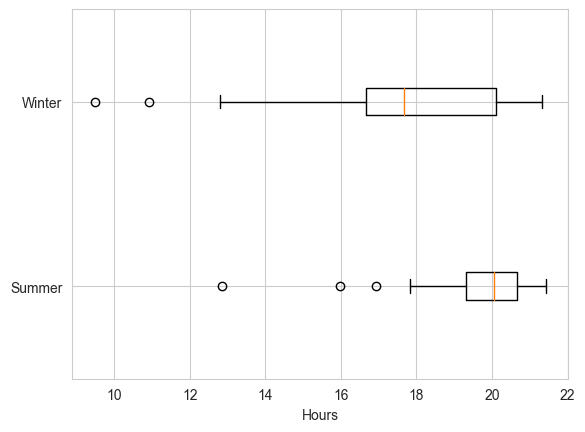

In [9]:
def hour_as_float(time: dt.time) -> float:
    """
    param time: time in type of datetime.time
    return: time in type of float, <hour.minute/60>
    """
    (h, m) = (time.hour, time.minute/60.)
    return h+m

def plot_by_seasons(df1: pd.DataFrame, df2: pd.DataFrame) -> plt.plot:
    """
    param df1: Dataframe of runs in one season
    param df2: Data Frame of runs in another season
    return: a boxplot showing the range of hours I ran at, per season
    """
    df1_hours = [hour_as_float(h) for h in df1["Time"]]
    df2_hours = [hour_as_float(h) for h in df2["Time"]]
    hours_data = [df1_hours, df2_hours]
    result = plt.boxplot(hours_data, vert=False)
    plt.yticks([1, 2], ["Summer", "Winter"])
    plt.xlabel("Hours")
    return result

boxplot_seasons = plot_by_seasons(summer_runs, winter_runs)
plt.show()

In [10]:
# data normalization
winter_runs.loc[winter_runs["Time"] < dt.time(hour=12), "Time"] = dt.time(hour=12)
summer_runs.loc[summer_runs["Time"] < dt.time(hour=18), "Time"] = dt.time(hour=18)

In [11]:
# updating the main data frame
def update_five_km_df():
    five_km_runs.update(winter_runs, overwrite=True)
    five_km_runs.update(summer_runs, overwrite=True)

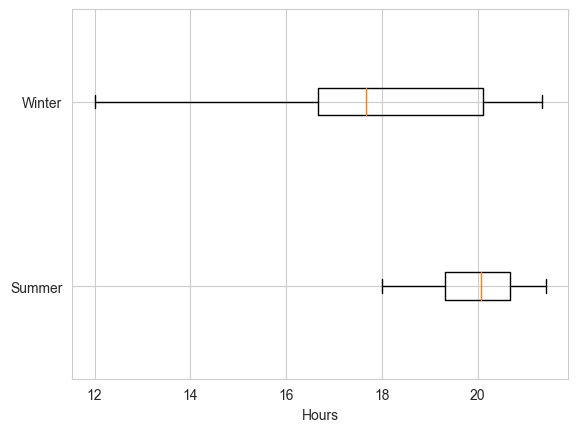

In [12]:
# presenting the updated plot
update_five_km_df()
boxplt_seasons = plot_by_seasons(summer_runs, winter_runs)
plt.show()

As seen, in cold months I usually run earlier while at warm month the range is narrow as well as it's later.

In [13]:
def quartiles_of_season(df: pd.DataFrame) -> tuple:
    """
    param df: dataframe with runs of a season
    return: a tuple floats representing the quartiles of the run hour dispersal
    """
    hours_data = []
    for t in df["Time"]:
        hours_data.append(hour_as_float(t))
    season_box = plt.boxplot(hours_data, vert=False)
    qur1 = [round(min(item.get_xdata()), 1) for item in season_box['boxes']]
    qur2 = [round(item.get_xdata()[0], 1) for item in season_box['medians']]
    qur3 = [round(max(item.get_xdata()), 1) for item in season_box['boxes']]
    plt.close() # for not showing the plot
    return qur1[0], qur2[0], qur3[0]

def float_as_hour(time: float) -> dt.time:
    """
    param time: time in type of float, <hour.minute/60>
    return: time in type of datetime.time
    """
    return dt.timedelta(hours=time)

# presenting the main running range
for season_df in [summer_runs, winter_runs]:
    (q1, q2, q3) = quartiles_of_season(season_df)
    print(season_df["Season"][0], "runs are usually between", float_as_hour(q1), "and", float_as_hour(q3))
    print(season_df["Season"][0], "median is", float_as_hour(q2), "\n")

Summer runs are usually between 19:18:00 and 20:42:00
Summer median is 20:06:00 

Winter runs are usually between 16:42:00 and 20:06:00
Winter median is 17:42:00 



#### Speed per Hour

In [14]:
def kde_speed_by_hour_season(df1: pd.DataFrame, df2:pd.DataFrame) -> plt.subplot:
    """
    param df1: dataframe of runs for one season
    param df2: dataframe of runs for second season
    return: subplots of scatter avg. speed by hour for both dfs
    """
    fig, axs = plt.subplots(1, 2)
    fig.supxlabel("Hour")

    # Summer
    axs[0].set_title(df1["Season"][0])
    sns.kdeplot(x = [hour_as_float(t) for t in df1["Time"]], y = df1["Avg Speed"], fill = True, ax=axs[0], cmap="Oranges")

    # Winter
    axs[1].set_title(df2["Season"][0])
    sns.kdeplot(x = [hour_as_float(t) for t in df2["Time"]], y = df2["Avg Speed"], fill = True, ax=axs[1], cmap="Blues")

    return fig.tight_layout()

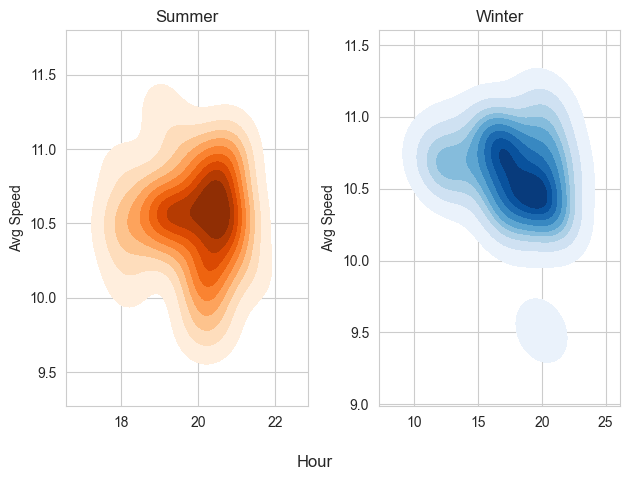

In [15]:
figure = kde_speed_by_hour_season(summer_runs, winter_runs)
plt.show()

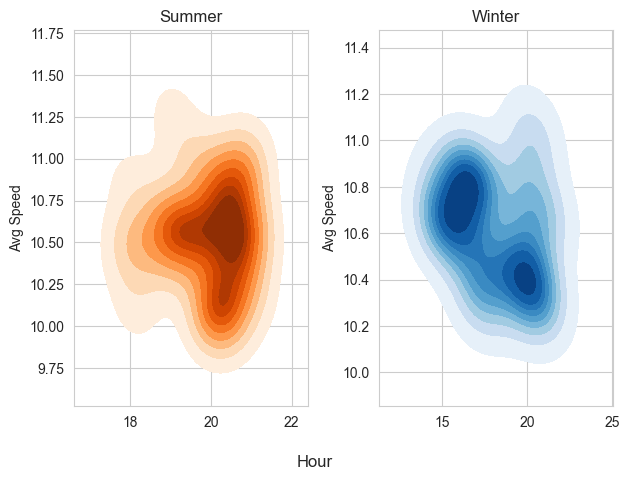

In [16]:
# data normalization
winter_runs.loc[winter_runs["Time"] < dt.time(hour=15), "Time"] = dt.time(hour=15)
winter_runs.loc[winter_runs["Avg Speed"] < 10.25, "Avg Speed"] = 10.25
summer_runs.loc[summer_runs["Time"] > dt.time(hour=21), "Time"] = dt.time(hour=21)
summer_runs.loc[summer_runs["Avg Speed"] < 10, "Avg Speed"] = 10
plot_seasons = kde_speed_by_hour_season(summer_runs, winter_runs)
plt.show()

# updating the five km df with the changes
update_five_km_df()

By looking at both graphs, it is shows that around 8pm I'm faster at summer than rather than in winter time by ~0.2 km\h.
Furthermore, at midday winter time I run faster than most runs in summer, perhaps because of the temperature differences.
In conclusion, it seems that I run faster at warm hours

#### Average speed per hour range

In [17]:
def avg_speed_per_hour_range(df: pd.DataFrame) -> pd.DataFrame:
    """
    param df: dataframe of runs
    return: a new dataframe that shows avg. speed for range of hours
    """
    col_list = ["Range", "Start Hour", "Avg Speed", "Run Count"]
    result = pd.DataFrame(columns = col_list)
    result["Start Hour"] = list(set([t.hour for t in df["Time"]]))
    result["Range"] = [str(h) + "-" + str(h+1) for h in result["Start Hour"]]
    result[["Avg Speed", "Run Count"]] = 0 # initializing

    for time in df["Time"]:
        result.loc[result["Start Hour"] == time.hour, "Run Count"] += 1
        result.loc[result["Start Hour"] == time.hour, "Avg Speed"] += df["Avg Speed"]
    result["Avg Speed"] = result["Avg Speed"] / result["Run Count"]
    result = result.drop("Start Hour", axis=1)
    return result

In [18]:
# Summer avg. speed data
avg_speed_per_hour_range(summer_runs).sort_values(by="Avg Speed", ascending=False, ignore_index=True)

,Range,Avg Speed,Run Count
0,19-20,10.67,12
1,21-22,10.67,2
2,18-19,10.59,9
3,20-21,10.29,27


In [19]:
# Winter avg. speed data
avg_speed_per_hour_range(winter_runs).sort_values(by="Avg Speed", ascending=False, ignore_index=True)

,Range,Avg Speed,Run Count
0,20-21,11.08,7
1,18-19,10.96,1
2,19-20,10.72,4
3,16-17,10.47,6
4,21-22,10.45,1
5,15-16,10.38,5
6,17-18,10.25,4


By looking at both dataframe, it looks like I run faster around 8pm - which is also showed in the plot above

#### Average speed per weekday

In [20]:
def avg_speed_per_weekday(df: pd.DataFrame) -> pd.DataFrame:
    """
    param df: dataframe of runs
    return: a new dataframe that shows avg. speed for every weekday
    """
    col_list = ["Day", "Avg Speed", "Runs Count"]
    week_days = {"Sunday": 6, "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5}
    result = pd.DataFrame(columns = col_list)
    result["Day"] = week_days.keys()
    result[["Avg Speed", "Runs Count"]] = 0

    for day in df["Date"]:
        result.loc[result["Day"] == pd.to_datetime(day).day_name(), "Runs Count"] += 1
        result.loc[result["Day"] == pd.to_datetime(day).day_name(), "Avg Speed"] += df["Avg Speed"].apply(np.sum)
    result["Avg Speed"] = result["Avg Speed"] / result["Runs Count"]
    return result

In [21]:
# Summer avg. speed per day
avg_speed_per_weekday(summer_runs)

,Day,Avg Speed,Runs Count
0,Sunday,10.59,4
1,Monday,10.67,9
2,Tuesday,10.29,7
3,Wednesday,10.67,6
4,Thursday,10.57,12
5,Friday,10.18,1
6,Saturday,10.13,11


My running days at summer were Monday, Thursday and Saturday, so it looks like I usually passed Monday run

In [22]:
# Winter avg. speed per day
avg_speed_per_weekday(winter_runs)

,Day,Avg Speed,Runs Count
0,Sunday,10.38,3
1,Monday,10.47,3
2,Tuesday,10.25,7
3,Wednesday,10.96,3
4,Thursday,10.72,5
5,Friday,11.08,3
6,Saturday,10.45,4


My running days at winter were Tuesday, Thursday and Saturday, so it looks like I usually passed Thursday and Saturday runs. I tend to pass more on runs on winter due to the cold weather

#### Connection between speed and feel after a run

In [23]:
def countplot_speed_per_feel(df: pd.DataFrame) -> plt:
    """
    param df: dataframe of runs
    return: dispersal plot of the self feel per avg. speed
    """
    plot = sns.lmplot(df, x="Self Feel", y="Avg Speed", hue="Season")
    return plot

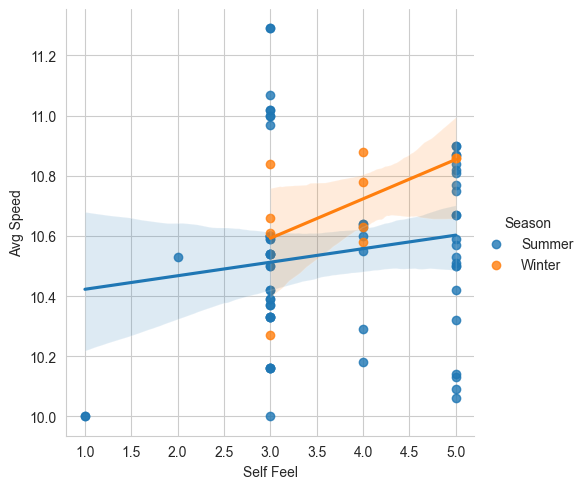

In [24]:
figure = countplot_speed_per_feel(five_km_runs)
plt.show()

Both lines have a positive coefficient, make sense that I fell better when I run faster

#### Avg. speed per run place

In [25]:
def avg_speed_per_location(df: pd.DataFrame) -> pd.DataFrame:
    """
    param df: dataframe full of runs
    return: a dataframe showing the average speed per the location of the run
    """
    col_list = ["Location", "Avg Speed", "Run Count"]
    result = pd.DataFrame(columns = col_list)
    result["Location"] = list(set(df["Location"]))
    # initializing
    result[["Avg Speed", "Run Count"]] = 0
    for lctn in df["Location"]:
        result.loc[result["Location"] == lctn, "Run Count"] += 1
        result.loc[result["Location"] == lctn, "Avg Speed"] += df["Avg Speed"].apply(np.sum)
    result["Avg Speed"] = result["Avg Speed"] / result["Run Count"]
    return result

In [26]:
# Fastest location in average in summer runs
avg_speed_per_location(summer_runs).sort_values(by="Avg Speed", ascending=False).reset_index(drop=True)

,Location,Avg Speed,Run Count
0,Beer Sheva,10.67,32
1,Ein Vered,10.59,18


In [27]:
# Fastest location in average in winter runs
avg_speed_per_location(winter_runs).sort_values(by="Avg Speed", ascending=False).reset_index(drop=True)

,Location,Avg Speed,Run Count
0,Beer Sheva,10.47,17
1,Ein Vered,10.38,11


Looks like I run faster in Ein Vered, which is interesting because the climate there is tougher to run at compared to Beer Sheva. Maybe it's because most of my Ein Vered runs are with Ofek which make me more competitive.

#### Average speed by average stride

In [28]:
def countplot_speed_per_stride(df: pd.DataFrame) -> plt:
    """
    param df: dataframe of runs
    return: dispersal plot of the avg. stride per avg. speed
    """
    plot = sns.lmplot(df, x="Avg Stride Length", y="Avg Speed", hue="Season")
    return plot

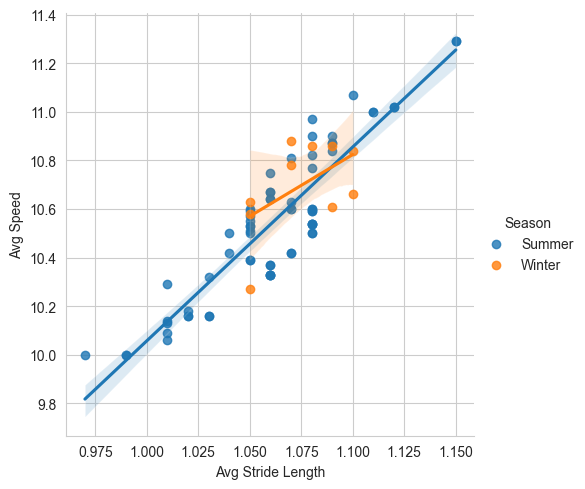

In [29]:
figure = countplot_speed_per_stride(five_km_runs)
plt.show()

So, wider strides mean a faster run. Noted

#### Pearson correlation


In [30]:
# In order to show the correlations, I'll first categorize the features with data type "object"
corr_data = five_km_runs.copy()
cols_to_drop = ["Activity Type", "Max HR", "Max Run Cadence", "Avg Pace", "Best Pace", "Moving Time", "Elapsed Time", "Min Elevation", "Max Elevation"]
corr_data = corr_data.drop(cols_to_drop, axis=1)
for col in corr_data.dtypes.to_dict():
    if corr_data.dtypes.to_dict()[col] == "object":
        corr_data[col] = corr_data[col].astype('category').cat.codes

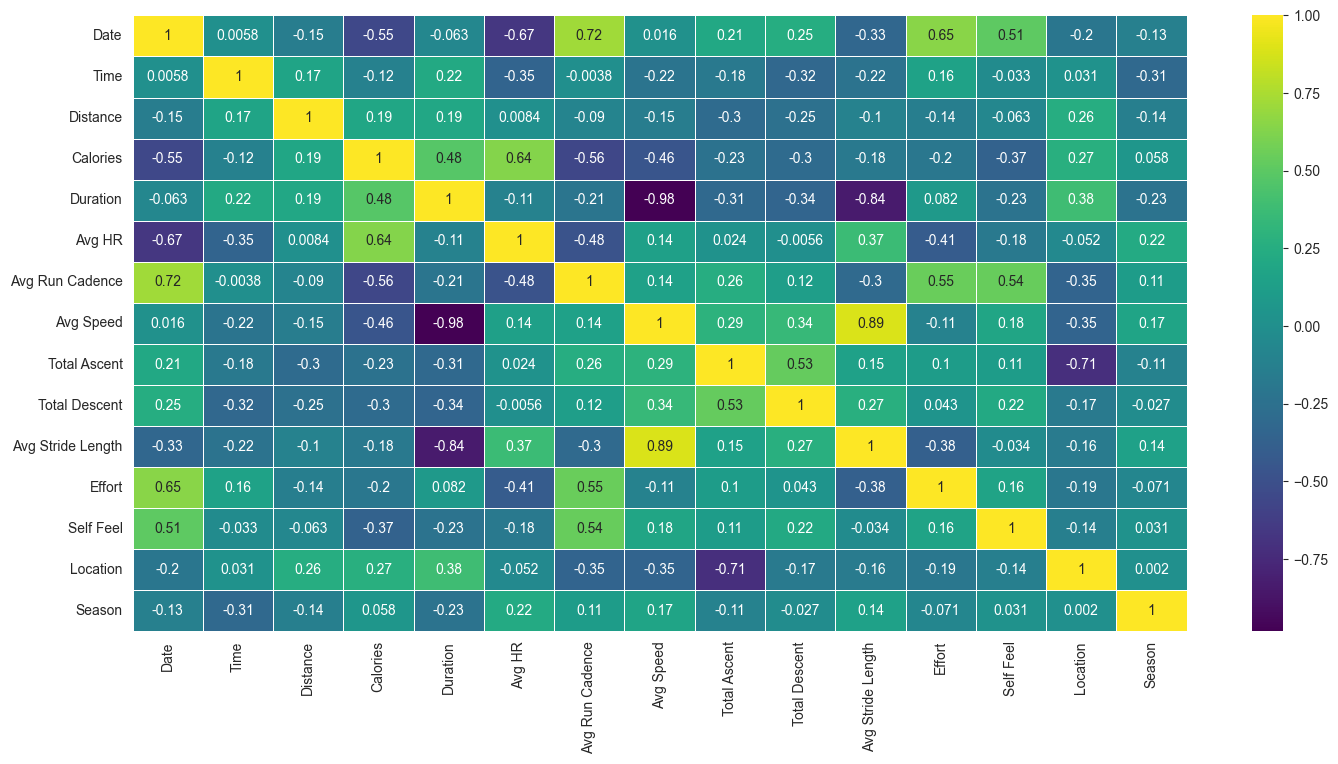

In [31]:
plt.figure(figsize = (17, 8))
sns.heatmap(corr_data.corr(method='pearson'), annot = True, linewidths = 0.5, cmap='viridis')
plt.show()